In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from rhessys import utilities as rh
import hydro.objective_fxns as ofx
import ntpath
from hydro import objective_fxns as ob
from IPython.display import clear_output
import ipyparallel as p
import ProgressBar as pb
from pymail import alert
import time

In [2]:
C = p.Client()

In [3]:
C.ids

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [4]:
view = C.load_balanced_view()

In [39]:
calname = 'et_cal57'
m = np.loadtxt('/RHESSys/jemez/scripts/%s_m.txt'%calname)
ksat = np.loadtxt('/RHESSys/jemez/scripts/%s_ksat.txt'%calname)
gw1 = np.loadtxt('/RHESSys/jemez/scripts/%s_gw1.txt'%calname)
gw2 = np.loadtxt('/RHESSys/jemez/scripts/%s_gw2.txt'%calname)
#gsmax = np.loadtxt(prfx+'gsmax.txt')
#sd = np.loadtxt(prfx+'sd.txt')
rd = np.loadtxt('/RHESSys/jemez/scripts/%s_rd.txt'%calname)
po = np.loadtxt('/RHESSys/jemez/scripts/%s_po.txt'%calname)
pa = np.loadtxt('/RHESSys/jemez/scripts/%s_pa.txt'%calname)
lai = np.loadtxt('/RHESSys/jemez/scripts/%s_lai.txt'%calname)
#sd = np.loadtxt('/RHESSys/jemez/scripts/%s_sd.txt'%calname)

In [6]:
strt = 2010
nd = 2010

In [7]:
# load ET calibration data
FT = pd.read_pickle('./data/VCM_2.pcl')
FT['wateryear'] = FT.index.map(rh.wateryear)
FT_daily = FT.loc[(FT.wateryear>=strt) & (FT.wateryear<=nd),:]
FT_weekly = FT_daily.resample('W',how=np.sum)
FT_monthly = FT_daily.resample('M',how=np.sum)

/Users/barnhatb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
/Users/barnhatb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


In [8]:
# load streamflow calibration data
Q = pd.read_pickle('./data/lower_lajara_specific_discharge.pcl')
Q['wateryear'] = Q.index.map(rh.wateryear)
Q_daily = Q.loc[(Q.wateryear>=strt) & (Q.wateryear<=nd),:]
Q_weekly = Q_daily.resample('W',how=np.sum)
Q_monthly = Q_daily.resample('M',how=np.sum)

/Users/barnhatb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
/Users/barnhatb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


In [9]:
%%px
import numpy as np
import pandas as pd
from rhessys import utilities as rh
import hydro.objective_fxns as ofx
# set bounds on the data
strt = 2010
nd = 2010
# load ET data
FT = pd.read_pickle('/Volumes/Users/Theo/projects/RHESSys/jemez/data/VCM_2.pcl')
FT['wateryear'] = FT.index.map(rh.wateryear)
FT_daily = FT.loc[(FT.wateryear>=strt) & (FT.wateryear<=nd),:]
FT_weekly = FT_daily.resample('W',how=np.sum)
FT_monthly = FT_daily.resample('M',how=np.sum)
# load streamflow data
Q = pd.read_pickle('/Volumes/Users/Theo/projects/RHESSys/jemez/data/lower_lajara_specific_discharge.pcl')
Q['wateryear'] = Q.index.map(rh.wateryear)
Q_daily = Q.loc[(Q.wateryear>=strt) & (Q.wateryear<=nd),:]
Q_weekly = Q_daily.resample('W',how=np.sum)
Q_monthly = Q_daily.resample('M',how=np.sum)

[stderr:4] 
/Users/barnhatb/anaconda/bin/ipengine:12: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
/Users/barnhatb/anaconda/bin/ipengine:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
/Users/barnhatb/anaconda/bin/ipengine:18: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
/Users/barnhatb/anaconda/bin/ipengine:19: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
[stderr:5] 
/Users/barnhatb/anaconda/bin/ipengine:12: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
/Users/barnhatb/anaconda/bin/ipengine:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
/Users/barnhatb/anaconda/bin/ipengine:18: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
/Users/bar

In [10]:
files = glob.glob('/RHESSys/jemez/out/%s/*_basin.daily'%calname)

In [11]:
cals = pd.DataFrame({'files':files})

In [12]:
cals.head()

,files
0,/RHESSys/jemez/out/et_cal57/et_cal57_0_basin.d...
1,/RHESSys/jemez/out/et_cal57/et_cal57_10000_bas...
2,/RHESSys/jemez/out/et_cal57/et_cal57_10001_bas...
3,/RHESSys/jemez/out/et_cal57/et_cal57_10002_bas...
4,/RHESSys/jemez/out/et_cal57/et_cal57_10003_bas...


In [13]:
cals.shape

(20000, 1)

In [24]:
def calc_obfx(fl):
    
    # extract idx
    idx = int(fl.split('/')[-1].split('_')[-2])
    prefix = '/Volumes/ullr'
    fl2 = '%s%s'%(prefix,fl)
    
    # load and process the data
    dat = rh.readRHESSysBasin(fl2)
    dat_daily = dat.loc[(dat.wateryear>=strt) & (dat.wateryear<=nd),:] # crop by water year
    dat_weekly = dat.resample('W', how= np.sum)
    dat_monthly = dat.resample('M', how= np.sum)
    
    # compute ET metrics
    nse_ET_daily = ofx.nashsut(FT_daily.ET,dat_daily.ET) # daily NSE
    nse_ET_weekly = ofx.nashsut(FT_weekly.ET,dat_weekly.ET) # weekly NSE
    nse_ET_monthly = ofx.nashsut(FT_monthly.ET,dat_monthly.ET) # monthly NSE
    pe_ET_daily = ofx.percenterror (FT_daily.ET,dat_daily.ET) # daily PE
    pe_ET_weekly = ofx.percenterror(FT_weekly.ET,dat_weekly.ET) # weekly PE
    pe_ET_monthly = ofx.percenterror(FT_monthly.ET,dat_monthly.ET) # monthly PE
    
    # compute Streamflow metrics
    nse_SF_daily = ofx.nashsut(Q_daily.discharge,dat_daily.streamflow) # daily NSE
    nse_SF_weekly = ofx.nashsut(Q_weekly.discharge,dat_weekly.streamflow) # weekly NSE
    nse_SF_monthly = ofx.nashsut(Q_monthly.discharge,dat_monthly.streamflow) # monthly NSE
    pe_SF_daily = ofx.percenterror (Q_daily.discharge,dat_daily.streamflow) # daily PE
    pe_SF_weekly = ofx.percenterror(Q_weekly.discharge,dat_weekly.streamflow) # weekly PE
    pe_SF_monthly = ofx.percenterror(Q_monthly.discharge,dat_monthly.streamflow) # monthly PE
    
    nse_et_wt = 0.25
    pe_et_wt = 0.25
    nse_sf_wt = 0.25
    pe_sf_wt = 0.25
    
    
    # compute daily metric
    #daily = np.nanmean(np.array([nse_ET_daily,nse_SF_daily,(1-(pe_ET_daily/100.)),(1-(pe_SF_daily/100.))]))
    
    daily = np.nansum([nse_et_wt*nse_ET_daily,nse_sf_wt*nse_SF_daily,pe_et_wt*(1-(pe_ET_daily/100.)),pe_sf_wt*(1-(pe_SF_daily/100.))])
    
    # compute weekly metric
    #weekly = np.nanmean([nse_ET_weekly,nse_SF_weekly,(1-(pe_ET_weekly/100.)),(1-(pe_SF_weekly/100.))])
        
    weekly = np.nansum([nse_et_wt*nse_ET_weekly,nse_sf_wt*nse_SF_weekly,pe_et_wt*(1-(pe_ET_weekly/100.)),pe_sf_wt*(1-(pe_SF_weekly/100.))])
    
    # compute monthly metric
    #monthly = np.nanmean([nse_ET_monthly,nse_SF_monthly,(1-(pe_ET_monthly/100.)),(1-(pe_SF_monthly/100.))])
    
    monthly = np.nansum([nse_et_wt*nse_ET_monthly,nse_sf_wt*nse_SF_monthly,pe_et_wt*(1-(pe_ET_monthly/100.)),pe_sf_wt*(1-(pe_SF_monthly/100.))])
    
    return (idx,nse_ET_daily,nse_ET_weekly,nse_ET_monthly,pe_ET_daily,pe_ET_weekly,pe_ET_monthly,nse_SF_daily,
            nse_SF_weekly,nse_SF_monthly,pe_SF_daily,pe_SF_weekly,pe_SF_monthly,daily,weekly,monthly)

In [25]:
res = view.map(calc_obfx,cals.files)

In [26]:
p = pb.ProgressBar(len(cals))

In [27]:
while res.ready() == False:
    p.animate_ipython(res.progress)
    time.sleep(2)

alert.send_alert('barnhatb@colorado.edu','Processing %s has finished'%calname,'Your script has finished')

[*****************99%******************]  19702 of 20000 complete


In [28]:
%px pwd

Out[4:6]: u'/Volumes/Users/Theo/projects'

Out[5:6]: u'/Volumes/Users/Theo/projects'

Out[6:6]: u'/Volumes/Users/Theo/projects'

Out[7:6]: u'/Volumes/Users/Theo/projects'

Out[8:6]: u'/Volumes/Users/Theo/projects'

Out[9:6]: u'/Volumes/Users/Theo/projects'

Out[10:6]: u'/Volumes/Users/Theo/projects'

Out[11:6]: u'/Volumes/Users/Theo/projects'

Out[12:5]: u'/Volumes/ullr'

Out[13:5]: u'/Volumes/ullr'

Out[14:5]: u'/Volumes/ullr'

Out[15:5]: u'/Volumes/ullr'

In [21]:
res.ready()

True

In [29]:
idx,nse_ET_daily,nse_ET_weekly,nse_ET_monthly,pe_ET_daily,pe_ET_weekly,pe_ET_monthly,nse_SF_daily,nse_SF_weekly,nse_SF_monthly,pe_SF_daily,pe_SF_weekly,pe_SF_monthly,daily,weekly,monthly = zip(*res.result())

In [40]:
tmp1 = pd.DataFrame({'rd':rd,'m':m,'ksat':ksat,'po':po,'pa':pa,'idx':np.arange(0,len(cals)),'lai':lai,'gw1':gw1,'gw2':gw2})
tmp2 = pd.DataFrame({'idx':idx,'nse_ET_daily':nse_ET_daily,'nse_ET_weekly':nse_ET_weekly,'nse_ET_monthly':nse_ET_monthly,
                     'pe_ET_daily':pe_ET_daily,'pe_ET_weekly':pe_ET_weekly,'pe_ET_monthly':pe_ET_monthly,
                     'nse_SF_daily':nse_SF_daily,'nse_SF_weekly':nse_SF_weekly,'nse_SF_monthly':nse_SF_monthly,
                     'pe_SF_daily':pe_SF_daily,'pe_SF_weekly':pe_SF_weekly,'pe_SF_monthly':pe_SF_monthly,
                     'daily':daily,'weekly':weekly,'monthly':monthly})

df = pd.merge(left=tmp1,right=tmp2,on='idx')

In [41]:
df.to_pickle('./data/%s.pcl'%calname)

In [32]:
var = 'monthly'
idx = df[var].idxmax()
#idx = 16861
#calname = 'et_cal54'
dat = rut.readRHESSysBasin('/RHESSys/jemez/out/%s/%s_%s_basin.daily'%(calname,calname,idx))
dat_daily = dat.loc[(dat.wateryear>=strt)&(dat.wateryear<=nd)]
dat_monthly = dat_daily.resample('M',how=np.nansum)

#[('%s: %s'%(key,df.loc[df[var]==df[var].max()][key].as_matrix())) for key in df.columns]

/Users/barnhatb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


In [33]:
idx

8111

In [34]:
df.loc[df.monthly == df.monthly.max()]

,idx,ksat,m,pa,po,rd,daily,monthly,nse_ET_daily,nse_ET_monthly,...,nse_SF_daily,nse_SF_monthly,nse_SF_weekly,pe_ET_daily,pe_ET_monthly,pe_ET_weekly,pe_SF_daily,pe_SF_monthly,pe_SF_weekly,weekly
8111,8111,440.81,19.024,0.068,3.644,1.991,0.422869,0.726032,-0.865502,0.220276,...,0.577751,0.697226,0.606689,1.103659,0.555708,0.841689,0.973782,0.78161,1.017541,0.487282


In [38]:
df.describe()

,idx,ksat,m,pa,po,rd,daily,monthly,nse_ET_daily,nse_ET_monthly,...,nse_SF_daily,nse_SF_monthly,nse_SF_weekly,pe_ET_daily,pe_ET_monthly,pe_ET_weekly,pe_SF_daily,pe_SF_monthly,pe_SF_weekly,weekly
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,9999.500000,351.607231,9.950961,1.210906,1.885809,4.512041,-16.759634,-14.008103,-1.036184,-1.434540,...,-67.926431,-56.532904,-66.051819,1.126854,0.744218,0.847693,6.465372,5.752601,6.658709,-16.346856
std,5773.647028,202.419746,5.774777,0.699313,1.098389,2.027680,18.828635,14.763044,0.207937,0.495072,...,75.359757,59.038172,72.562820,0.188022,0.090225,0.069054,3.906262,3.479867,3.974615,18.163447
min,0.000000,1.010000,0.011000,0.001000,0.001000,1.000000,-137.582852,-70.601577,-1.636699,-2.754919,...,-551.616606,-282.429962,-436.283704,0.822750,0.436835,0.628001,0.450186,0.339666,0.458422,-108.840070
25%,4999.750000,176.647500,4.877000,0.612750,0.928000,2.760000,-25.855958,-22.316245,-1.157787,-1.743346,...,-104.426145,-89.773240,-102.169724,0.952757,0.677793,0.788420,3.029223,2.652327,3.137805,-25.370366
50%,9999.500000,351.755000,9.971000,1.206000,1.889000,4.505000,-9.809686,-8.817423,-0.999845,-1.410346,...,-40.180141,-36.048523,-39.230640,1.089460,0.730082,0.837730,6.236240,5.543665,6.461241,-9.656574
75%,14999.250000,528.467500,14.940000,1.821000,2.835000,6.282000,-1.994279,-1.819276,-0.877122,-1.146796,...,-8.804825,-7.678400,-8.754848,1.313606,0.793156,0.910213,9.453372,8.508406,9.853066,-1.994366
max,19999.000000,699.980000,19.999000,2.419000,3.799000,7.999000,0.461232,0.726032,-0.289827,0.304403,...,0.719917,0.941170,0.748358,1.474088,0.961153,1.011247,18.088782,15.840091,17.843647,0.540967


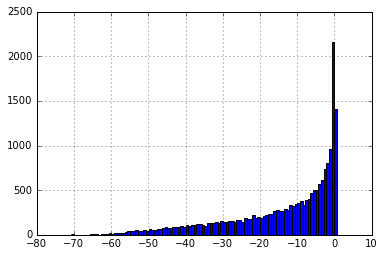

In [35]:
df.monthly.hist(bins=100)

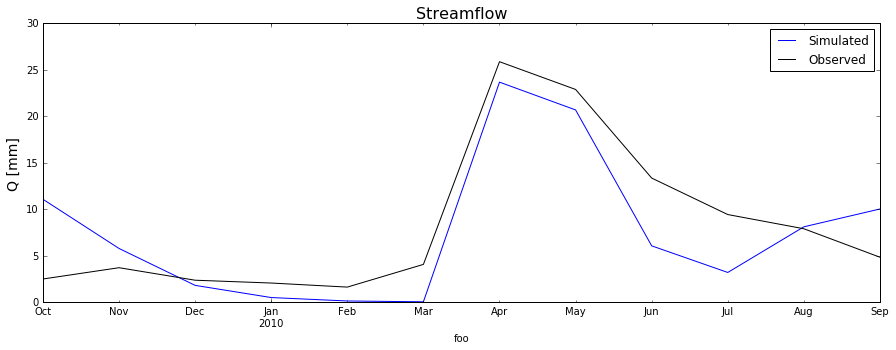

In [36]:
plt.figure(figsize=(15,5))
dat_monthly.streamflow.plot(label='Simulated',c='b')
Q_monthly.discharge.plot(label='Observed',c='k')
plt.legend()
plt.title('Streamflow', fontsize=16)
plt.ylabel('Q [mm]', fontsize=14)

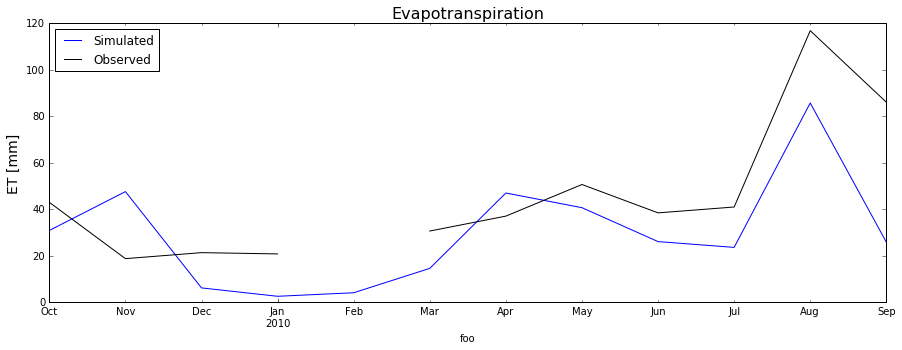

In [37]:
plt.figure(figsize=(15,5))
dat_monthly.ET.plot(label='Simulated',c='b')
FT_monthly.ET.plot(label='Observed',c='k')
plt.legend(loc='best')
plt.title('Evapotranspiration', fontsize=16)
plt.ylabel('ET [mm]', fontsize=14)

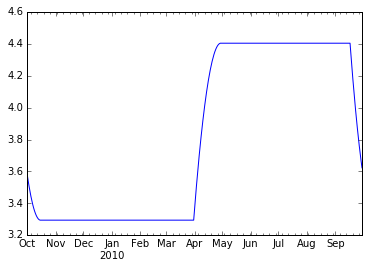

In [187]:
dat_daily.lai.plot()

In [125]:
calname

'et_cal54'